# Wind visualization

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import plotly
from scipy.interpolate import griddata

import sys
sys.path.append('../../../AsymptoticSolver/')
sys.path.append('..')

from Utilities.coord_func import cart2pol
from Utilities.add_var import add_u_polar
from AsymptoticSolver import polar_dft, polar_idft, pick_fourier_comp

%matplotlib notebook

/sw/tools/python/anaconda3/2019.03/skl/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/sw/tools/python/anaconda3/2019.03/skl/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### 1. Get data

Initial data is taken from NARVAL simulation for the 17.08.2016 1200 UTC (initialized at 0000 UTC).
Center is calculated with method of centroid pressure.


__Constants:__  
lev_start: Level from where the calculation should start  
km: Radius around the cyclone center  
r_earth: Radius of earth  
r_rad: Radius around the cyclone center in radians

In [2]:
lev_start= 45             
km       = 250                           
r_earth  = 6371                     
r_rad    = km / r_earth

In [3]:
# Data for centerline
center_file       = "../Data/center_fiona.npy" 
center = np.load(center_file)
x_center = center[:,0]
y_center = center[:,1]

# Initial data
ds_orig = xr.open_dataset('../../../../init_data/dei4_NARVALII_2016081700_fg_DOM01_ML_0012.nc')
#ds_orig = add_u_polar(ds_orig,center)

# Number of levels in file (highest index is lowest level -> p-system)
nlev = len(ds_orig.height.values)
height = ds_orig.z_ifc.values


Extract u,v,w,u_phi and u_r seperately.

In [5]:
da_u = ds_orig.u[0]
da_v = ds_orig.v[0]
da_w = ds_orig.w[0]
#da_u_phi=ds_orig.u_phi[0]
#da_u_r = ds_orig.u_r[0]

bg_u = np.empty([nlev])
bg_v = np.empty([nlev])
bg_w = np.empty([nlev])

for i in range(0, nlev):
    bg_u[i] = da_u.values[i].mean()
    bg_v[i] = da_v.values[i].mean()
    bg_w[i] = da_w.values[i].mean()


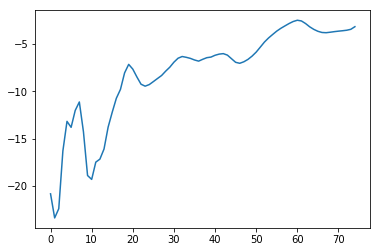

In [6]:
plt.figure()
plt.plot(bg_u)


In [ ]:
ds_orig.u[0,33].mean()

#ds_orig.z_ifc[33]

In [ ]:
bg_u
plt.figure()
plt.tripcolor(ds_orig.clon, ds_orig.clat, ds_orig.u.isel(time=0, height=70))
plt.colorbar()

### 2. Polar coordinate transformation

Select a variable of interest because a memory error occurse when trying to manipulate the whole data set. Create a new polar coord. grid to interpolate the lon-lat data onto.


In [ ]:
var_da = da_u_phi

# Extract region containing cyclone
lonlat_box = {'lon_up':-0.57,'lon_down':-0.68, 'lat_up': 0.17, 'lat_down': 0.30}

 # Select region of interest
var_da = var_da.where(var_da['clon'] < lonlat_box['lon_up'], drop=True)
var_da = var_da.where(var_da['clon'] > lonlat_box['lon_down'], drop=True)
var_da = var_da.where(var_da['clat'] > lonlat_box['lat_up'], drop=True)
var_da = var_da.where(var_da['clat'] < lonlat_box['lat_down'], drop=True)



In [ ]:
cellID = var_da.ncells.values

lon = var_da.clon.values
lat = var_da.clat.values

# Create new grid
r_grid = np.linspace(0,r_rad,1000).transpose()
phi_grid = np.linspace(-np.pi,np.pi,1000,endpoint=False)
r_grid_da = xr.DataArray(r_grid, coords=[('r', r_grid)])
phi_grid_da = xr.DataArray(phi_grid, coords=[('phi', phi_grid)])



Select a single level that shall be evaluated

In [ ]:
# Set level number
i = 65 

center_index = i- (nlev - len(center))-1
lev_index = i-1
lev_height = height[lev_index,0]

# Calculate r and phi for single level
r,phi = cart2pol(lon,lat,center[center_index,])

# Unit vector for r and phi
#e_r = np.array([np.cos(phi), np.sin(phi)])
#e_phi= np.array([-np.sin(phi), np.cos(phi)])

Transform the lat lon positions into polar coordinates. After that the data is interpolated onto a circle around the cyclone center where the locations are given in phi and r.

In [ ]:
x_grid = x_center[center_index] + r_grid_da*np.cos(phi_grid_da)
y_grid = y_center[center_index] + r_grid_da*np.sin(phi_grid_da)

# Create new lon and lat positions using polar coordinates 
# (necessary to have all points for interpolation method):
x_polar = [x_center[center_index] + r_grid[j]*np.cos(phi_grid) \
            for j in range(len(r_grid))]
x_polar = np.asarray(x_polar).reshape((1,len(r_grid)*len(r_grid)))
y_polar = [y_center[center_index] + r_grid[j]*np.sin(phi_grid) \
            for j in range(len(r_grid))]
y_polar = np.asarray(y_polar).reshape((1,len(r_grid)*len(r_grid)))

Now the actual interpolation can be done. This is relatively slow when using the whole data set so extracting the regions of interest is important.

In [ ]:
values = var_da.values[lev_index]

lonlat_points = np.asarray([var_da.clon.values[:], var_da.clat.values[:]]).transpose()
polar_points = np.asarray([x_polar, y_polar]).reshape((2,len(x_polar[0]))).transpose()

# remap variables for circles with constant radius around center
var_remap = griddata(lonlat_points, values, polar_points, method='cubic')
var_remap = var_remap.reshape((len(r_grid),len(phi_grid)))

# Add polar coordinates as dimensions
var_polar_da = xr.DataArray(var_remap, coords={ 'r':('r',r_grid), \
                    'phi':('phi', phi_grid), 'x': x_grid , 'y': y_grid }, \
                    dims={'r': r_grid, 'phi':phi_grid })
var_polar_da = var_polar_da.fillna(0.)


### 2. Discrete Fourier transformation  
In the following steps the Fourier modes can be extracted for the given variable on the given level.

In [ ]:
# All modes
fvar = polar_dft(var_polar_da, polar_dim='phi')
fvar_i = polar_idft(fvar, polar_dim='phi')

# Select specific modes
# 0
fvar0 = fvar.copy()
fvar0[1:] = 0.
fvar0_i = polar_idft(fvar0)

# 1
fvar1 = fvar.copy()
fvar1[0] = 0.
fvar1[2:] = 0.
fvar1_i = polar_idft(fvar1)

# -1
fvar_neg1 = fvar.copy()
fvar_neg1[0:-1] = 0.
fvar_neg1_i = polar_idft(fvar_neg1)



In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.pcolor(fvar_i.x, fvar_i.y, xr.ufuncs.real(fvar_i))
ax.title.set_text('U_phi (%s m)' %  np.int(lev_height))
cbar = plt.colorbar(cs, ax=ax)
cbar.ax.set_ylabel('m s^-1')
#plt.show()

In [ ]:
fig = plt.figure(figsize=(9,3))
ax = fig.add_subplot(131)
cs = ax.pcolor(fvar_i.x, fvar_i.y, xr.ufuncs.real(fvar_neg1_i))
ax.title.set_text('U_phi F mode -1 (%s m)' %  np.int(lev_height))
cbar = plt.colorbar(cs, ax=ax)

ax = fig.add_subplot(132)
ax.axes.get_yaxis().set_visible(False)
cs = ax.pcolor(fvar0_i.x, fvar0_i.y, xr.ufuncs.real(fvar0_i))
#cs = ax.pcolor(fvar0_i.x, fvar0_i.y, xr.ufuncs.real(fvar_p4_i))
ax.title.set_text('Fourier mode 0')
cbar = plt.colorbar(cs, ax=ax)

ax = fig.add_subplot(133)
ax.axes.get_yaxis().set_visible(False)
cs = ax.pcolor(fvar1_i.x, fvar1_i.y, xr.ufuncs.real(fvar1_i))
ax.title.set_text('Fourier mode 1')
cbar = plt.colorbar(cs, ax=ax)
cbar.ax.set_ylabel('m s^-1')
